In [1]:
import torch
dev = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(dev)
print(dev)

cuda


In [2]:
from google.colab import files
files.upload()
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d uciml/sms-spam-collection-dataset
!unzip sms-spam-collection-dataset.zip

sms-spam-collection-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  sms-spam-collection-dataset.zip
replace spam.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [3]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
nltk.download('punkt')
nltk.download('stopwords')
tokenizer = RegexpTokenizer(r'\w+')
tqdm.pandas()

MAX_LEN = 128
def make_clean(s) :
  tokens = np.array(tokenizer.tokenize(s.lower()))
  tokens = tokens[~np.isin(tokens, stopwords.words())]
  return ' '.join(tokens)

df = pd.read_csv('spam.csv', encoding = "ISO-8859-1")
df['clean'] = df['v2'].progress_apply(make_clean)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
from keras.preprocessing import sequence

vocab = np.unique(tokenizer.tokenize(' '.join(df.clean.values.tolist())))
idx2word = {i+1:w for i,w in tqdm(enumerate(vocab), total=vocab.shape[0])}
idx2word[0] = 'PAD'
word2idx = {w:i for i,w in tqdm(idx2word.items())}

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:520: FutureWarn

ImportError: ignored

In [0]:
def sent2idxs(s) :
  return list(map(word2idx.__getitem__, tokenizer.tokenize(s)))

df['idxs'] = df.clean.progress_apply(sent2idxs)
df['paded'] = sequence.pad_sequences(df.idxs, maxlen=MAX_LEN, padding='post', truncating='post').tolist()

In [0]:
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch import tensor
batch_size = 32

# dataset = TensorDataset(tensor(df.idxs.values.tolist()), tensor((df.v1=='ham').values.tolist()))
# train_size = int(0.8 * len(dataset))
# val_size = len(dataset) - train_size
# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
# train_dataloader = DataLoader(
#             train_dataset,
#             sampler = RandomSampler(train_dataset),
#             batch_size = batch_size
#         )

# validation_dataloader = DataLoader(
#             val_dataset,
#             sampler = SequentialSampler(val_dataset),
#             batch_size = batch_size
#         )

In [0]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df.paded.values.tolist(), 
                                                  (df['v1'].values=='ham').tolist(),
                                                  random_state=42,
                                                  test_size=0.2)

In [0]:
# Copy from https://github.com/JHart96/keras_elmo_embedding_layer/blob/master/elmo.py
# !pip install 'tensorflow==1.7.0'


from keras import backend as K
from keras.engine.topology import Layer
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np

class ELMoEmbedding(Layer):

    def __init__(self, idx2word, output_mode="default", trainable=True, **kwargs):
        assert output_mode in ["default", "word_emb", "lstm_outputs1", "lstm_outputs2", "elmo"]
        assert trainable in [True, False]
        self.idx2word = idx2word
        self.output_mode = output_mode
        self.trainable = trainable
        self.max_length = None
        self.word_mapping = None
        self.lookup_table = None
        self.elmo_model = None
        self.embedding = None
        super(ELMoEmbedding, self).__init__(**kwargs)

    def build(self, input_shape):
        self.max_length = input_shape[1]
        self.word_mapping = [x[1] for x in sorted(self.idx2word.items(), key=lambda x: x[0])]
        self.lookup_table = tf.contrib.lookup.index_to_string_table_from_tensor(self.word_mapping, default_value="<UNK>")
        self.lookup_table.init.run(session=K.get_session())
        self.elmo_model = hub.Module("https://tfhub.dev/google/elmo/3", trainable=self.trainable)
        super(ELMoEmbedding, self).build(input_shape)

    def call(self, x):
        x = tf.cast(x, dtype=tf.int64)
        sequence_lengths = tf.cast(tf.count_nonzero(x, axis=1), dtype=tf.int32)
        strings = self.lookup_table.lookup(x)
        inputs = {
            "tokens": strings,
            "sequence_len": sequence_lengths
        }
        return self.elmo_model(inputs, signature="tokens", as_dict=True)[self.output_mode]

    def compute_output_shape(self, input_shape):
        if self.output_mode == "default":
            return (input_shape[0], 1024)
        if self.output_mode == "word_emb":
            return (input_shape[0], self.max_length, 512)
        if self.output_mode == "lstm_outputs1":
            return (input_shape[0], self.max_length, 1024)
        if self.output_mode == "lstm_outputs2":
            return (input_shape[0], self.max_length, 1024)
        if self.output_mode == "elmo":
            return (input_shape[0], self.max_length, 1024)

    def get_config(self):
        config = {
            'idx2word': self.idx2word,
            'output_mode': self.output_mode 
        }
        return list(config.items())

In [0]:
import tensorflow as tf
from keras.models import Model
from keras.layers import *
from keras.optimizers import Adam


sentence_input = Input(shape=(len(x_train[0]),), dtype=tf.int64)
sentence_embedding = ELMoEmbedding(idx2word=idx2word, output_mode="elmo", trainable=False)(sentence_input)
convolution = Convolution1D(50, 3, padding='same', activation='relu')(sentence_embedding)
convolution = GlobalMaxPooling1D()(convolution)
dropout = Dropout(0.5)(convolution)
hidden = Dense(50, activation='relu')(dropout)
output = Dense(1, activation='sigmoid')(hidden)

model = Model(inputs=sentence_input, outputs=output)
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
model.summary()

# model.fit(x_train, y_train, batch_size=2, epochs=5, validation_data=(x_test, y_test))

In [23]:
[n.name for n in tf.get_default_graph().as_graph_def().node]


AttributeError: ignored

In [0]:
!pip install "tensorflow>=1.7.0"
!pip install tensorflow-hub

import tensorflow_hub as hub
import tensorflow as tf

elmo = hub.KerasLayer("https://tfhub.dev/google/elmo/3", trainable=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
def elmo_vectors(s, one=False):
  embeddings = elmo([s] if one else s, signature="default", as_dict=True)["elmo"]
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    return sess.run(tf.reduce_mean(embeddings,1))

In [0]:
def flatten(ll) :
  o = list()
  for l in ll :
    o += l
  return o

elmos = [elmo_vectors(df.clean[i:i+250].tolist()).tolist() for i in tqdm(range(0,df.shape[0],250))]
df['elmo'] = flatten(elmos)







  0%|          | 0/23 [00:00<?, ?it/s]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore






  4%|▍         | 1/23 [00:25<09:12, 25.12s/it]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore






  9%|▊         | 2/23 [00:50<08:47, 25.10s/it]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore






 13%|█▎        | 3/23 [01:15<08:24, 25.20s/it]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore






 17%|█▋        | 4/23 [01:41<08:02, 25.39s/it]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore






 22%|██▏       | 5/23 [02:08<07:43, 25.75s/it]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore






 26%|██▌       | 6/23 [02:34<07:21, 25.96s/it]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore






 30%|███       | 7/23 [03:02<07:04, 26.54s/it]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore






 35%|███▍      | 8/23 [03:29<06:40, 26.71s/it]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore






 39%|███▉      | 9/23 [03:56<06:17, 26.93s/it]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore






 43%|████▎     | 10/23 [04:24<05:53, 27.21s/it]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore






 48%|████▊     | 11/23 [04:52<05:28, 27.39s/it]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore






 52%|█████▏    | 12/23 [05:20<05:03, 27.59s/it]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore






 57%|█████▋    | 13/23 [05:49<04:38, 27.88s/it]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore






 61%|██████    | 14/23 [06:18<04:14, 28.24s/it]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore






 65%|██████▌   | 15/23 [06:47<03:47, 28.42s/it]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore






 70%|██████▉   | 16/23 [07:15<03:19, 28.54s/it]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore






 74%|███████▍  | 17/23 [07:44<02:51, 28.66s/it]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore






 78%|███████▊  | 18/23 [08:14<02:24, 28.89s/it]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore






 83%|████████▎ | 19/23 [08:43<01:56, 29.04s/it]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore






 87%|████████▋ | 20/23 [09:13<01:27, 29.19s/it]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore






 91%|█████████▏| 21/23 [09:43<00:58, 29.48s/it]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore






 96%|█████████▌| 22/23 [10:13<00:29, 29.65s/it]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore






100%|██████████| 23/23 [10:43<00:00, 27.97s/it]


In [0]:
from sklearn.model_selection import train_test_split

xtrain, xvalid, ytrain, yvalid = train_test_split(df['elmo'].values.tolist(), 
                                                  (df['v1'].values=='ham').tolist(),
                                                  random_state=42, 
                                                  test_size=0.2)

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

lreg = LogisticRegression()
lreg.fit(xtrain, ytrain)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
preds_valid = lreg.predict(xvalid)

In [0]:
f1_score(yvalid, preds_valid)

0.9943269726663228

In [0]:
len(yvalid)

NameError: ignored

In [0]:
!pip install transformers
from transformers import BertTokenizer
btokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

input_ids = []
attention_masks = []

for sent in tqdm(df['clean']):
    encoded_dict = btokenizer.encode_plus(
                        sent,
                        add_special_tokens = True,
                        max_length = 64,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor((df['v1'] == 'ham').astype(int).tolist())

In [0]:
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
batch_size = 32

dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
        )

In [0]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
import torch.nn as nn

# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.bert = BertForSequenceClassification.from_pretrained(
#                       "bert-base-uncased",
#                       num_labels = 2,
#                       output_attentions = False,
#                       output_hidden_states = False,
#                     )

#     def forward(self, x):
#         x = torch.softmax(self.bert(x)[0], dim=1)
#         return x

# model = Net()
model = BertForSequenceClassification.from_pretrained(
                      "bert-base-uncased",
                      num_labels = 2,
                      output_attentions = False,
                      output_hidden_states = False,
                    )
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [0]:
from transformers import get_linear_schedule_with_warmup
epochs = 10

optimizer = AdamW(model.parameters(), lr = 2e-4)
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [0]:
import random
import numpy as np

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

def train_epoch(model) :
    total_train_loss = 0
    for batch in tqdm(train_dataloader, total=len(train_dataloader)) :
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()        
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    avg_train_loss = total_train_loss / len(train_dataloader)
    return avg_train_loss

def test_epoch(model) :
  total_eval_accuracy = 0
  total_eval_accuracy = 0
  total_eval_accuracy = 0
  total_eval_loss = 0
  nb_eval_steps = 0
  for batch in tqdm(validation_dataloader, total=len(validation_dataloader)):
      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_labels = batch[2].to(device)
      with torch.no_grad():        
          (loss, logits) = model(b_input_ids, 
                                  token_type_ids=None, 
                                  attention_mask=b_input_mask,
                                  labels=b_labels)
      total_eval_loss += loss.item()
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()
  avg_val_loss = total_eval_loss / len(validation_dataloader)
  return avg_val_loss

train_losses = list()
test_losses = list()
for epoch_i in tqdm(range(epochs)):
  model.train()
  train_losses.append(train_epoch(model))
  model.eval()
  test_losses.append(test_epoch(model))

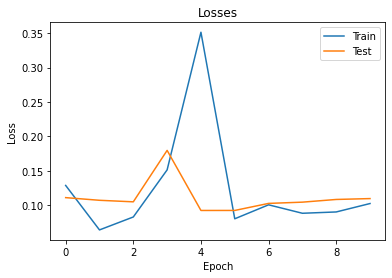

In [0]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label="Train")
plt.plot(test_losses, label="Test")
plt.legend()
plt.title("Losses")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

In [0]:
from sklearn import metrics
def cal_metrics(y_true, y_pred) :
  fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred, pos_label=1)
  return {
      "Accuracy": metrics.accuracy_score(y_true, y_pred),
      "AUC" : metrics.auc(fpr, tpr),
      "f1" : metrics.f1_score(y_true, y_pred, average='macro'),
      "Recall" : metrics.recall_score(y_true, y_pred, average='macro'),
      "Precision" : metrics.precision_score(y_true, y_pred, average='macro'),
  }

from scipy.special import softmax
true_labels, predictions = [], []
for batch in tqdm(validation_dataloader):
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch
  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)
  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  true_labels += label_ids.tolist()
  predictions += softmax(logits, axis=1).argmax(axis=1).tolist()

cal_metrics(true_labels, predictions)

{'AUC': 0.9680699192126523,
 'Accuracy': 0.9632286995515695,
 'Precision': 0.9014789860960635,
 'Recall': 0.9680699192126523,
 'f1': 0.9306853830536641}